<a href="https://colab.research.google.com/github/cjy-sc11/2025_machine_learning/blob/main/AS4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [21]:
import xml.etree.ElementTree as ET
import csv

# 解析 XML 檔案
tree = ET.parse('O-A0038-003.xml')
root = tree.getroot()

# 從 XML 中提取原始數據
namespace = {'cwa': 'urn:cwa:gov:tw:cwacommon:0.1'}
content = root.find('.//cwa:Content', namespace).text.strip()
grid_data = [row.split(',') for row in content.split('\n')]

# 初始參數設定
start_lon = 120.00  # 起始經度
start_lat = 21.88    # 起始緯度
resolution = 0.03    # 解析度
cols = 67            # 經度方向格點數
rows = 120           # 緯度方向格點數

# 初始化數據集
classification = []
regression = []

# 處理格點數據
for row_idx in range(rows):
    current_lat = start_lat + row_idx * resolution
    for col_idx in range(cols):
        current_lon = start_lon + col_idx * resolution

        # 解析科學記號數值
        value_str = grid_data[row_idx][col_idx].strip()
        value = float(value_str)

        # 分類數據集處理
        label = 1 if value != -999.0 else 0
        classification.append([
            round(current_lon, 5),
            round(current_lat, 5),
            label
        ])

        # 回歸數據集處理 (只保留有效值)
        if value != -999.0:
            regression.append([
                round(current_lon, 5),
                round(current_lat, 5),
                round(value, 1)
            ])

# 保存分類數據集
with open('temperature_classification.csv', 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(['Longitude', 'Latitude', 'Label'])
    writer.writerows(classification)

# 保存回歸數據集
with open('temperature_regression.csv', 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(['Longitude', 'Latitude', 'Temperature'])
    writer.writerows(regression)

print('數據轉換完成！')
print(f'分類數據集數量：{len(classification)} 筆')
print(f'回歸數據集數量：{len(regression)} 筆')


數據轉換完成！
分類數據集數量：8040 筆
回歸數據集數量：3495 筆


In [26]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import (train_test_split,
                                   RandomizedSearchCV)
from sklearn.ensemble import (RandomForestClassifier,
                            GradientBoostingRegressor)
from sklearn.metrics import (accuracy_score, confusion_matrix,
                             r2_score, mean_squared_error)
import seaborn as sns
from scipy.stats import randint, uniform

# ====================
# Optimized Model Class
# ====================
class EnhancedLearner:
    def __init__(self):
        self.clf_params = {
            'n_estimators': randint(150, 600),
            'max_depth': randint(4, 12),
            'min_samples_split': uniform(0.005, 0.15)
        }

        self.reg_params = {
            'n_estimators': randint(300, 800),
            'learning_rate': uniform(0.05, 0.25),
            'max_depth': randint(4, 10)
        }

    def train_clf(self, X, y):
        model = RandomizedSearchCV(
            estimator=RandomForestClassifier(class_weight='balanced'),
            param_distributions=self.clf_params,
            n_iter=25,
            cv=5,
            n_jobs=-1,
            random_state=42
        )
        model.fit(X, y)
        return model.best_estimator_

    def train_reg(self, X, y):
        model = RandomizedSearchCV(
            estimator=GradientBoostingRegressor(),
            param_distributions=self.reg_params,
            n_iter=25,
            cv=5,
            n_jobs=-1,
            random_state=42
        )
        model.fit(X, y)
        return model.best_estimator_

# ====================
# Data Pipeline
# ====================
def load_data():
    try:
        df_class = pd.read_csv('temperature_classification.csv')
        df_reg = pd.read_csv('temperature_regression.csv')
        return (
            df_class[['Longitude', 'Latitude']], df_class['Label'],
            df_reg[['Longitude', 'Latitude']], df_reg['Temperature']
        )
    except FileNotFoundError as e:
        print(f"Critical Error: {e.filename} missing")
        sys.exit(1)

# ====================
# Visualization Core (Fixed)
# ====================
def plot_performance(y_true_clf, y_pred_clf, y_true_reg, y_pred_reg):
    plt.figure(figsize=(15, 6))  # 修正參數格式

    # Classification panel
    plt.subplot(1, 2, 1)
    sns.heatmap(confusion_matrix(y_true_clf, y_pred_clf),
                annot=True, fmt='d', cmap='Blues',
                xticklabels=['Invalid', 'Valid'],
                yticklabels=['Invalid', 'Valid'])
    plt.title(f'Classification (Acc: {accuracy_score(y_true_clf, y_pred_clf):.2%})')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')

    # Regression panel
    plt.subplot(1, 2, 2)
    scatter = plt.scatter(y_true_reg, y_pred_reg, alpha=0.6,
                c=np.abs(y_true_reg - y_pred_reg),
                cmap='viridis', edgecolor='k')
    plt.plot([y_true_reg.min(), y_true_reg.max()],
             [y_true_reg.min(), y_true_reg.max()], 'r--')
    cbar = plt.colorbar(scatter)
    cbar.set_label('Absolute Error (°C)')
    plt.title(f'Regression (R²: {r2_score(y_true_reg, y_pred_reg):.2f})')
    plt.xlabel('Actual Temperature')
    plt.ylabel('Predicted Temperature')

    plt.tight_layout()
    plt.savefig('enhanced_model_performance.png', dpi=300, bbox_inches='tight')
    plt.close()

# ====================
# Execution Flow
# ====================
if __name__ == "__main__":
    X_clf, y_clf, X_reg, y_reg = load_data()

    # Model training
    learner = EnhancedLearner()

    # Classification
    X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(
        X_clf, y_clf, test_size=0.2, stratify=y_clf, random_state=42)
    best_clf = learner.train_clf(X_train_clf, y_train_clf)
    y_pred_clf = best_clf.predict(X_test_clf)

    # Regression
    X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(
        X_reg, y_reg, test_size=0.2, random_state=42)
    best_reg = learner.train_reg(X_train_reg, y_train_reg)
    y_pred_reg = best_reg.predict(X_test_reg)

    # Generate output
    plot_performance(y_test_clf, y_pred_clf, y_test_reg, y_pred_reg)

    print("\n=== Final Output ===")
    print("Saved: enhanced_model_performance.png")
    print(f"Classification Accuracy: {accuracy_score(y_test_clf, y_pred_clf):.2%}")
    print(f"Regression R²: {r2_score(y_test_reg, y_pred_reg):.2f}")
    print(f"Regression RMSE: {np.sqrt(mean_squared_error(y_test_reg, y_pred_reg)):.2f}°C")



=== Final Output ===
Saved: enhanced_model_performance.png
Classification Accuracy: 96.52%
Regression R²: 0.85
Regression RMSE: 2.22°C


圖表生成完成！請檢查以下文件：
- simplified_classification.png
- temperature_distribution.png


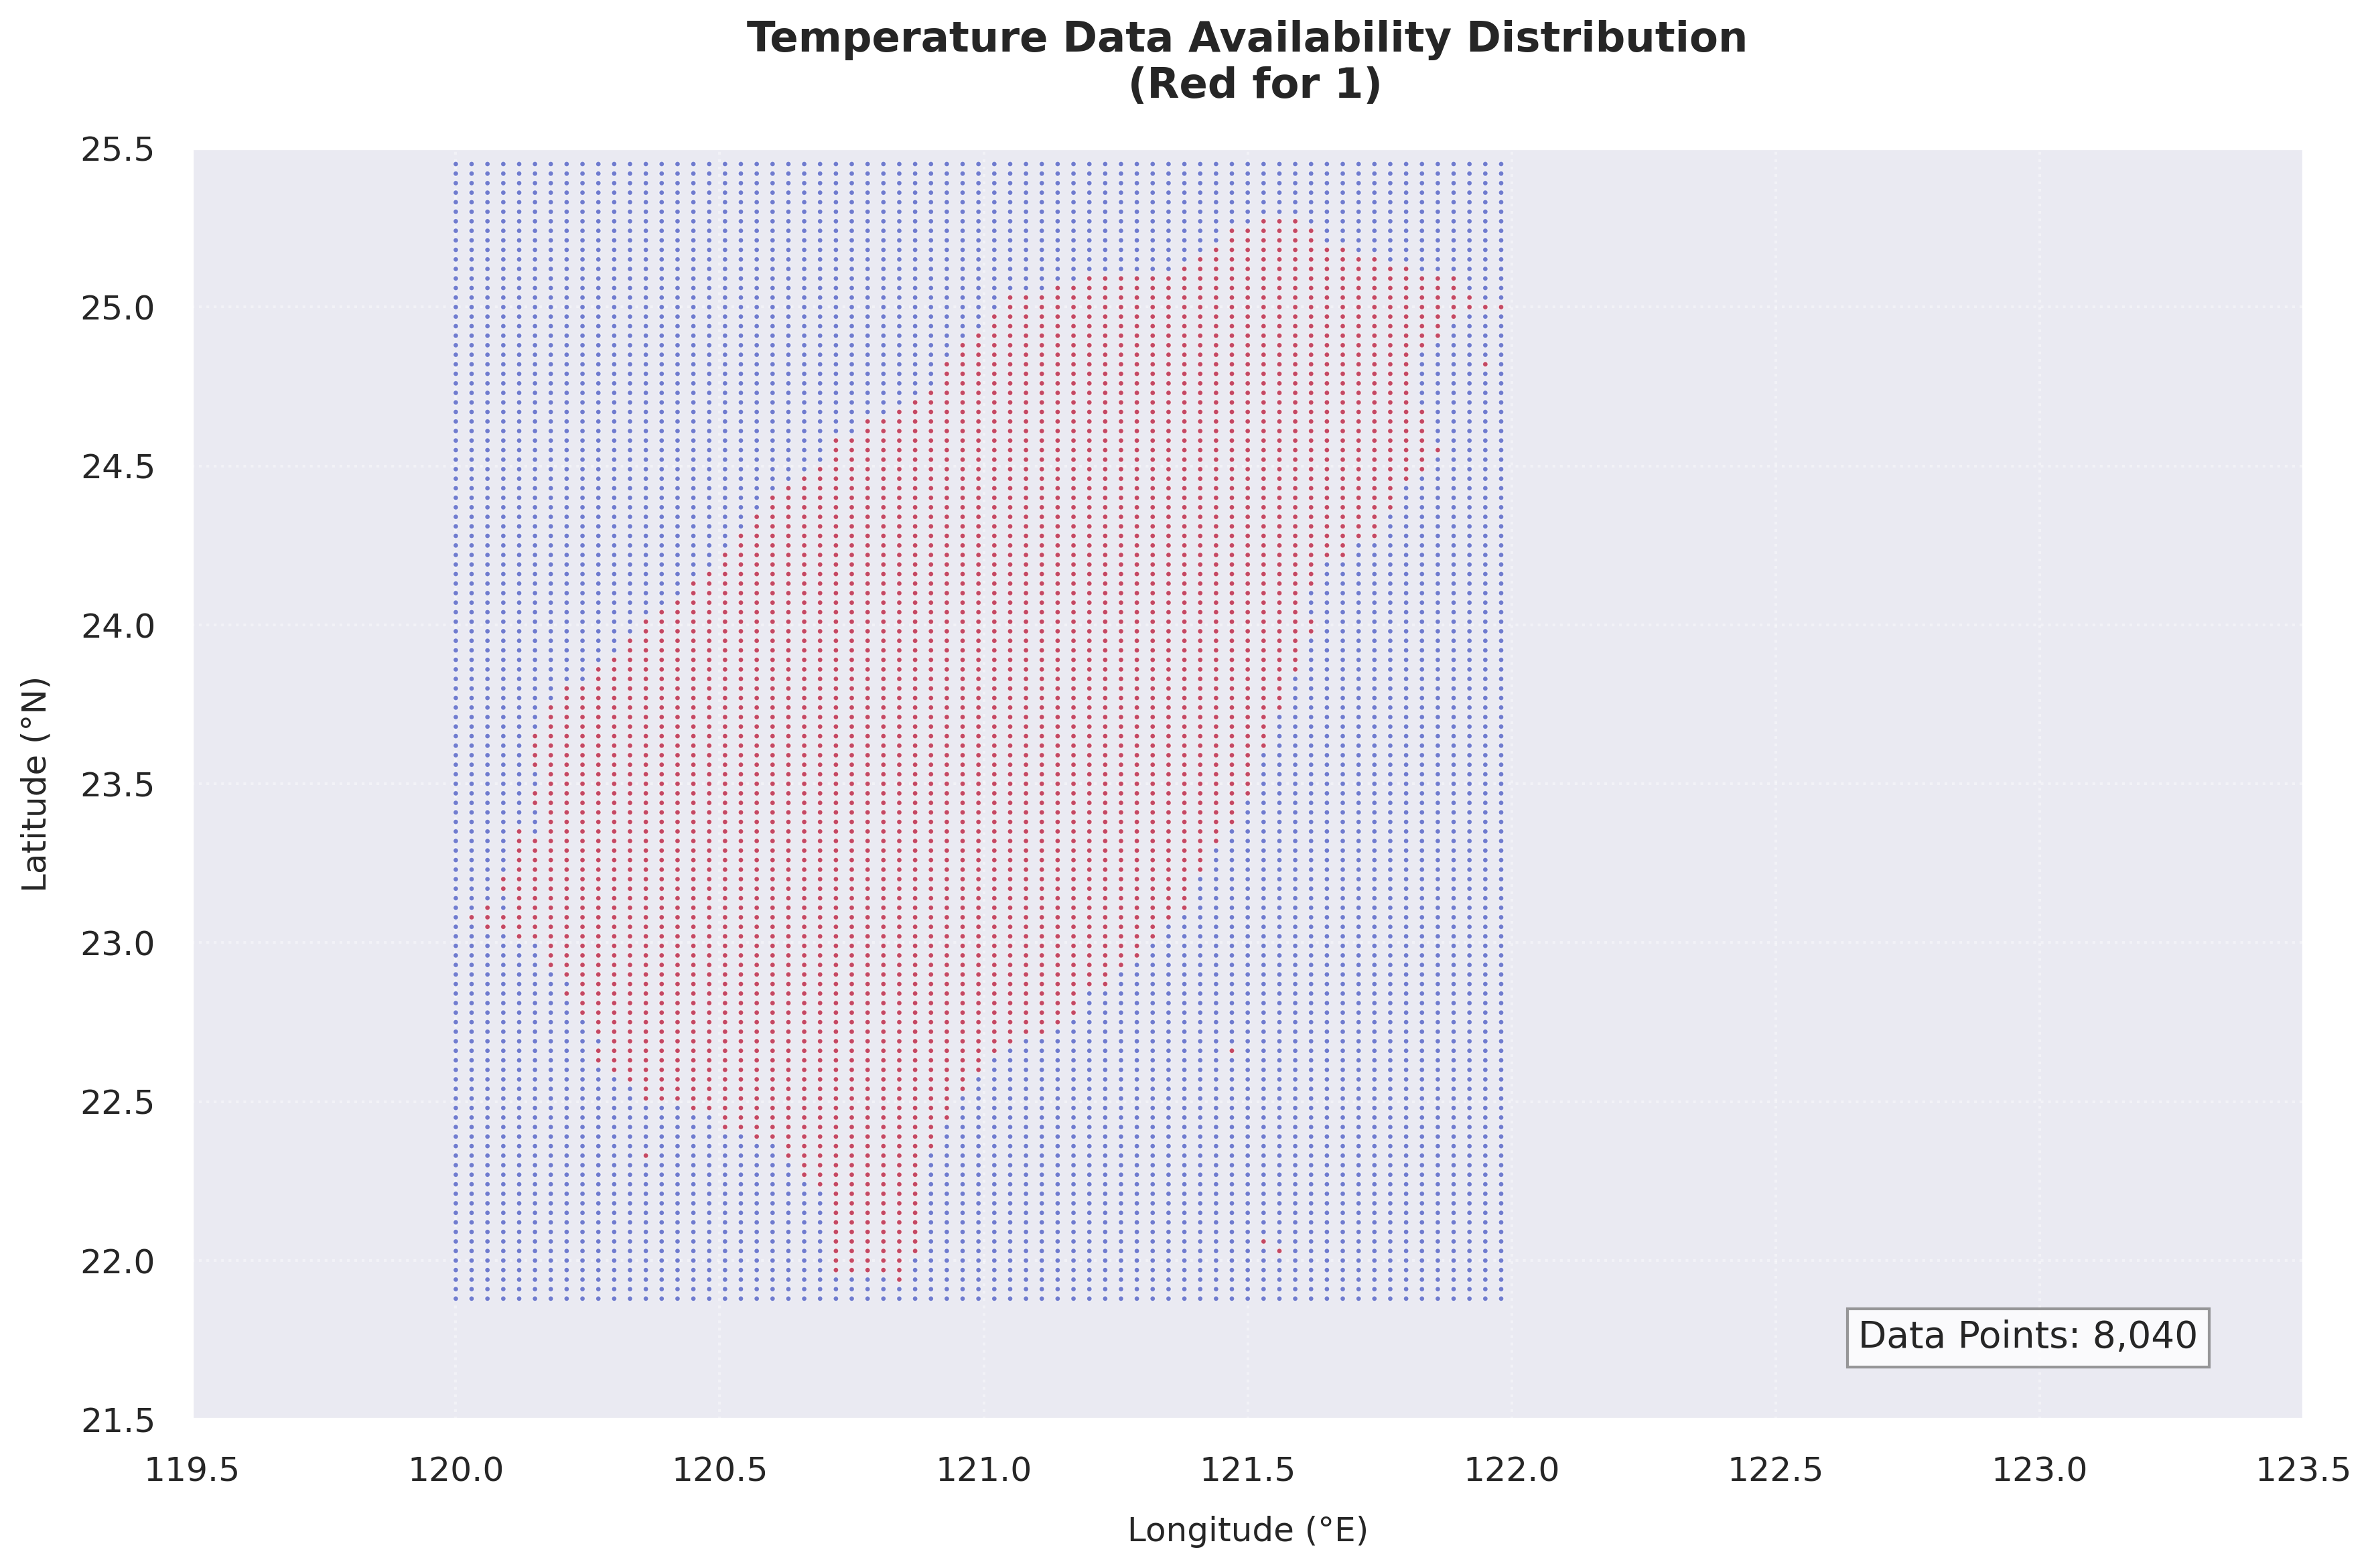

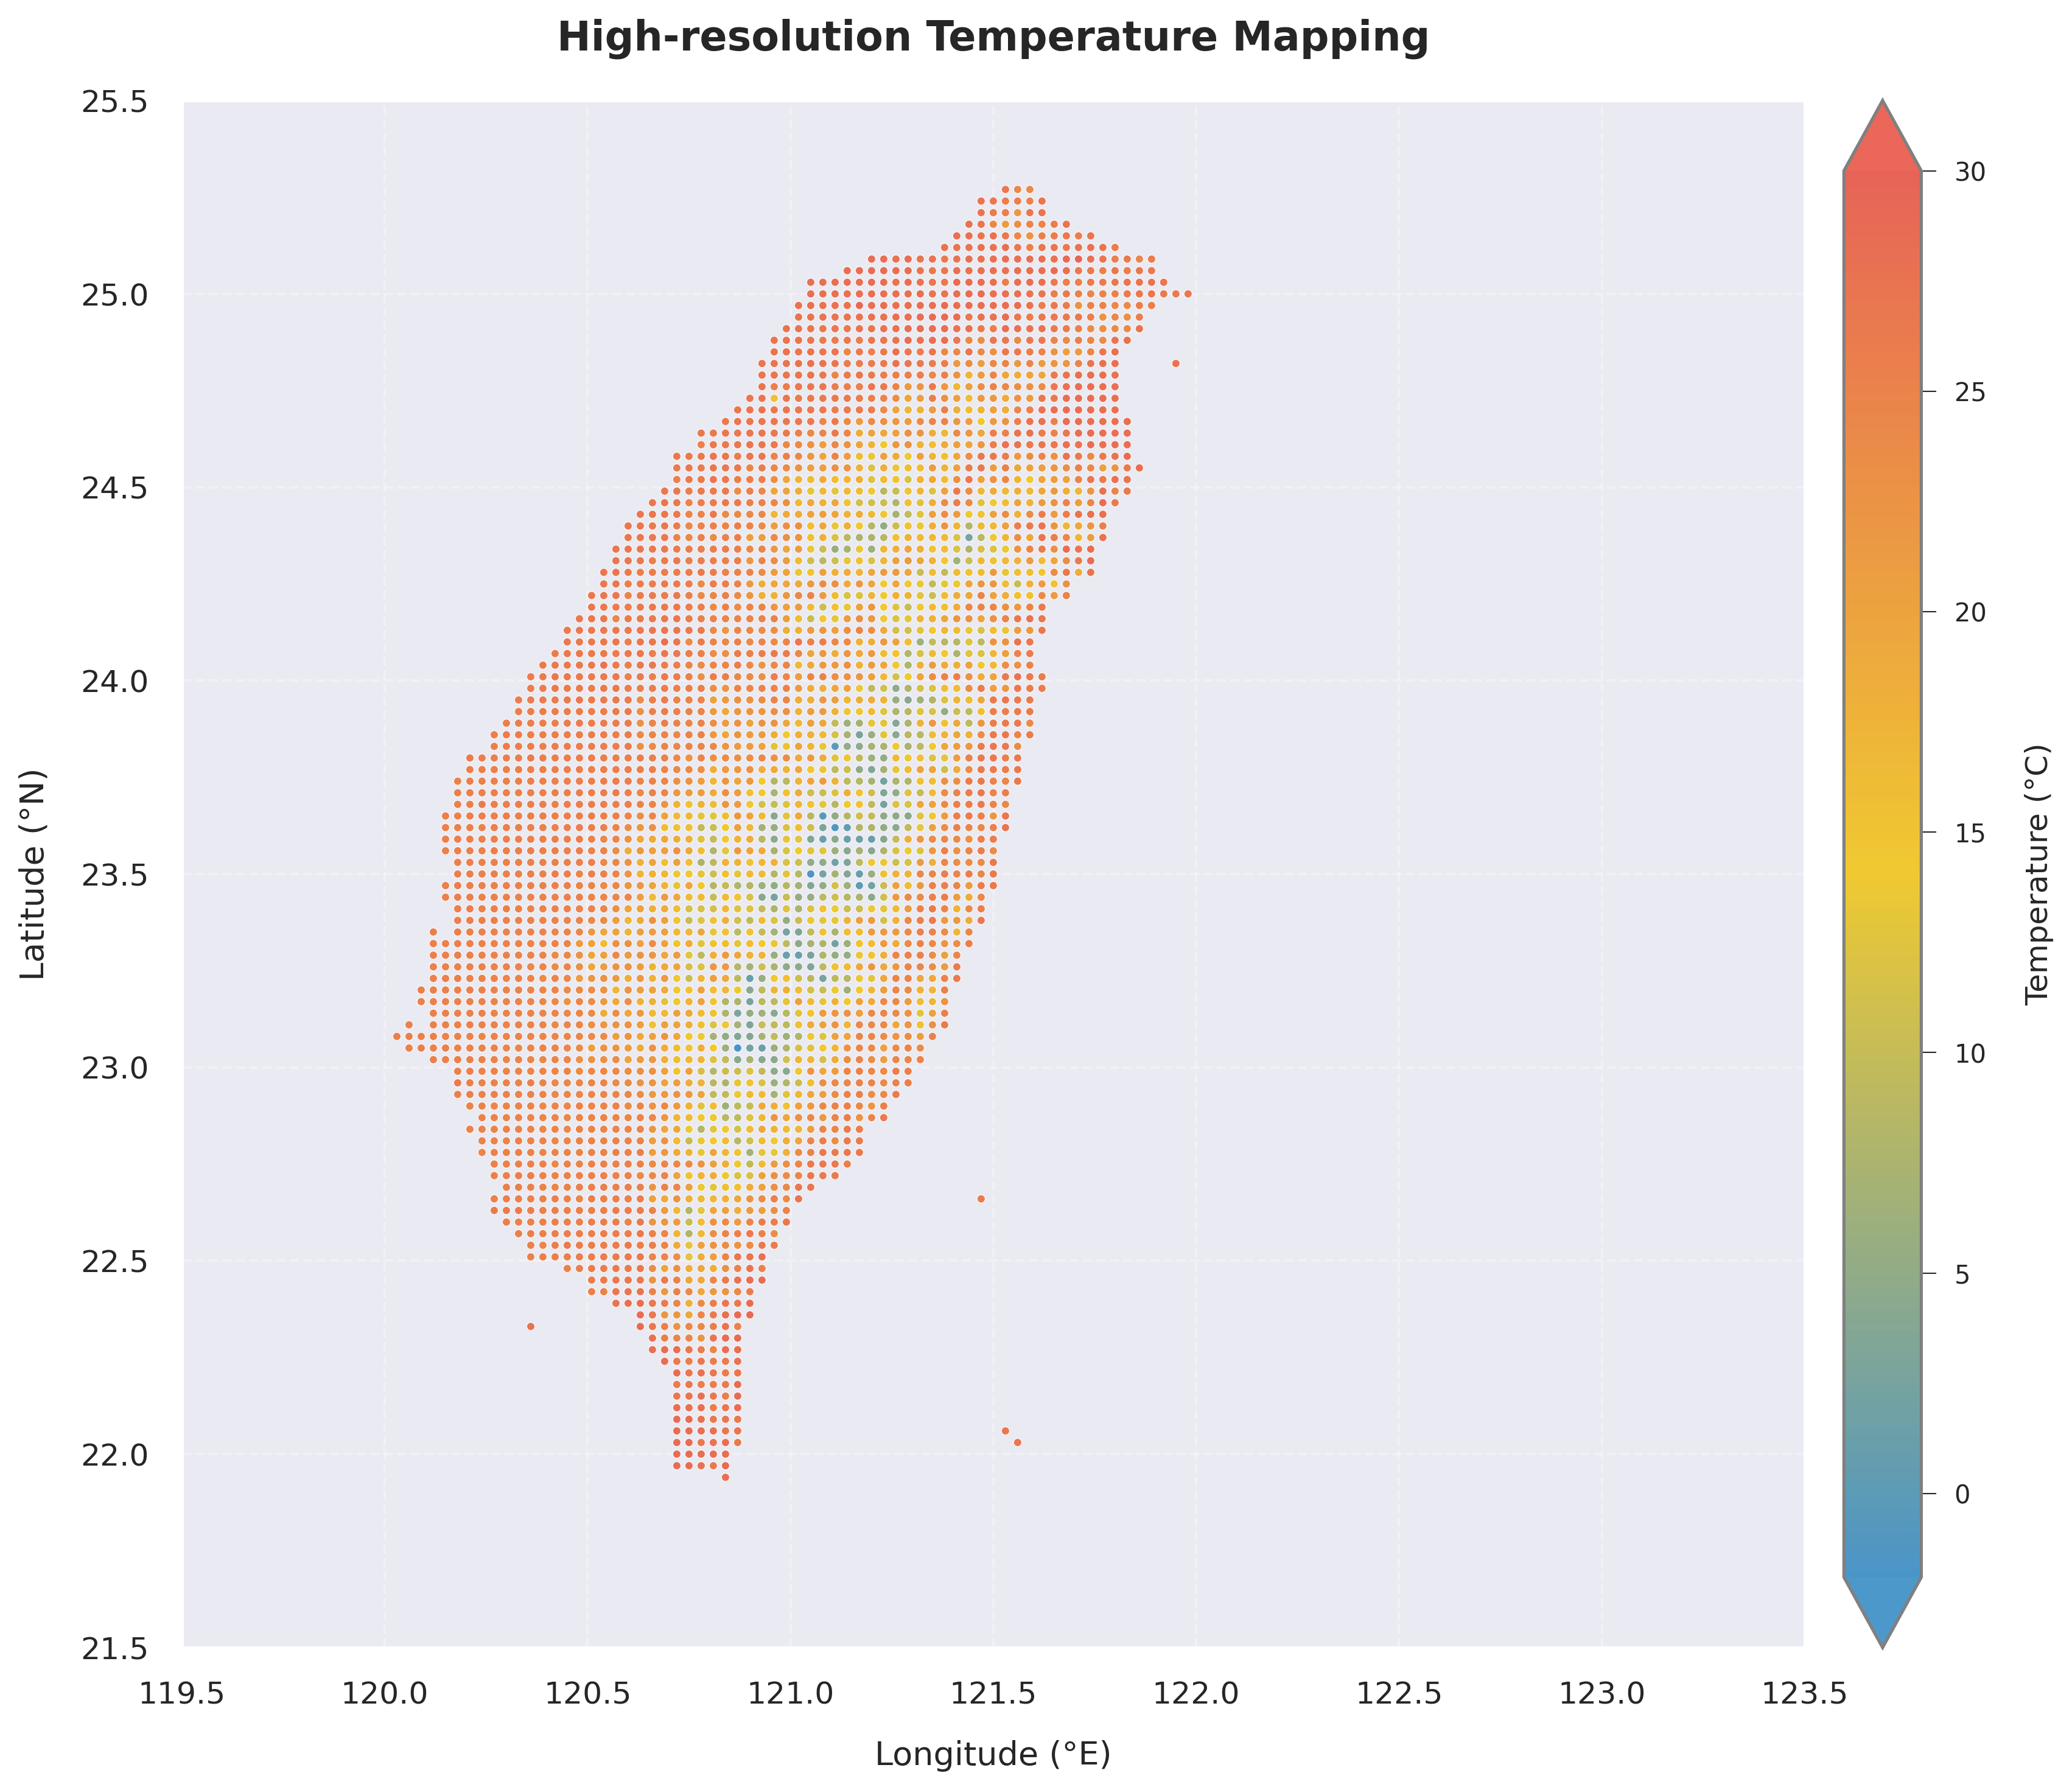

In [35]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap

# 設定專業科研風格
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_theme(context='notebook', font_scale=1.1)

# 自定義溫度色階 (藍→黃→紅)
temp_palette = ['#2E86C1', '#F1C40F', '#E74C3C']
temp_cmap = LinearSegmentedColormap.from_list('temperature', temp_palette, N=256)

# 數據載入與異常處理
try:
    df_class = pd.read_csv('temperature_classification.csv')
    df_reg = pd.read_csv('temperature_regression.csv')
except FileNotFoundError as e:
    raise SystemExit(f"數據文件缺失: {e.filename} 未找到，請確認文件路徑") from e

# 單一子圖配置 (原分類數據部分)
fig, ax = plt.subplots(figsize=(12, 8), dpi=300)  # 調整為單一圖像

# 數據存在性散點圖
scatter = ax.scatter(
    x=df_class['Longitude'],
    y=df_class['Latitude'],
    c=df_class['Label'],
    cmap='coolwarm',
    s=3.5,
    alpha=0.7,
    edgecolor='w',
    linewidth=0.3
)

ax.set_title('Temperature Data Availability Distribution\n (Red for 1)',
            fontsize=15, pad=18, fontweight='semibold')
ax.set_xlabel('Longitude (°E)', fontsize=12, labelpad=10)
ax.set_ylabel('Latitude (°N)', fontsize=12, labelpad=10)
ax.set_xlim(119.5, 123.5)
ax.set_ylim(21.5, 25.5)
ax.grid(True, linestyle=':', alpha=0.4)

# 添加比例尺註解
ax.text(0.95, 0.05,
       f'Data Points: {len(df_class):,}',
       transform=ax.transAxes,
       ha='right', va='bottom',
       bbox=dict(facecolor='white', alpha=0.8, edgecolor='gray'))

plt.tight_layout()
plt.savefig('simplified_classification.png', bbox_inches='tight', pad_inches=0.2)

# 溫度分布圖保持不變
plt.figure(figsize=(12, 10), dpi=300)
scatter2 = plt.scatter(
    x=df_reg['Longitude'],
    y=df_reg['Latitude'],
    c=df_reg['Temperature'],
    cmap=temp_cmap,
    s=10,
    alpha=0.85,
    edgecolor='w',
    linewidth=0.3,
    zorder=2
)

plt.title('High-resolution Temperature Mapping',
        fontsize=16, pad=20, fontweight='semibold')
plt.xlabel('Longitude (°E)', fontsize=13, labelpad=12)
plt.ylabel('Latitude (°N)', fontsize=13, labelpad=12)
plt.xlim(119.5, 123.5)
plt.ylim(21.5, 25.5)

# 增強色階標籤
cbar = plt.colorbar(scatter2, pad=0.02, extend='both')
cbar.set_label('Temperature (°C)', fontsize=12, labelpad=15)
cbar.ax.tick_params(labelsize=10, width=0.5)
cbar.outline.set_edgecolor('gray')

plt.grid(True, linestyle='--', alpha=0.3, zorder=1)
plt.tight_layout()
plt.savefig('temperature_distribution.png', bbox_inches='tight', dpi=350)

print("圖表生成完成！請檢查以下文件：\n- simplified_classification.png\n- temperature_distribution.png")
